# Binary-Class Tabular Model for Kaggle Playground Series Season 3 Episode 4 Using Python and TensorFlow Decision Forests
### David Lowe
### February 7, 2023

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Playground Series Season 3 Episode 4 dataset is a binary-class modeling situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions to give the Kaggle community a variety of reasonably lightweight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science. The dataset for this competition was generated from a deep learning model trained on the Credit Card Fraud Detection dataset. Feature distributions are close to but different from the original.

ANALYSIS: The Random Forest model performed the best with the training dataset. The model achieved a ROC/AUC benchmark of 0.9974. When we processed the test dataset with the final model, the model achieved a ROC/AUC score of 0.8108.

CONCLUSION: In this iteration, the Random Forest model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Playground Series Season 3, Episode 4

Dataset ML Model: Binary-Class classification with numerical features

Dataset Reference: https://www.kaggle.com/competitions/playground-series-s3e4

One source of potential performance benchmarks: https://www.kaggle.com/competitions/playground-series-s3e4/leaderboard

## Task 1 - Prepare Environment

In [1]:
# Install TensorFlow Decision Forests
!pip3 install tensorflow_decision_forests --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [3]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [4]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
import zipfile
import urllib
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import metrics

from sklearn.feature_selection import RFE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
# from tensorflow import keras
import tensorflow_decision_forests as tfdf

### 1.b) Set up the controlling parameters and functions

In [5]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the name for the class/label column
ORIGINAL_LABEL = 'Class'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 10
N_ITERATIONS = 1

# Set default modeling scoring metric
DEFAULT_METRICS = [tf.keras.metrics.AUC()]

# Define the directory locations and file names
ORIGINAL_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e04/creditcard.csv'
TRAIN_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e04/train.csv'
TEST_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e04/test.csv'
SUBMISSION_TEMPLATE = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e04/sample_submission.csv'
SUBMISSION_FILE = 'submission_decisionforests_'

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow version: 2.11.0
Found TensorFlow Decision Forests v1.2.0


In [6]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [7]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [8]:
df_dataset_import = pd.read_csv(TRAIN_DATASET)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id  Time        V1        V2        V3        V4        V5        V6  \
0   0   0.0  2.074329 -0.129425 -1.137418  0.412846 -0.192638 -1.210144   
1   1   0.0  1.998827 -1.250891 -0.520969 -0.894539 -1.122528 -0.270866   
2   2   0.0  0.091535  1.004517 -0.223445 -0.435249  0.667548 -0.988351   
3   3   0.0  1.979649 -0.184949 -1.064206  0.120125 -0.215238 -0.648829   
4   4   0.0  1.025898 -0.171827  1.203717  1.243900 -0.636572  1.099074   

         V7        V8  ...       V21       V22       V23       V24       V25  \
0  0.110697 -0.263477  ... -0.334701 -0.887840  0.336701 -0.110835 -0.291459   
1 -1.029289  0.050198  ...  0.054848 -0.038367  0.133518 -0.461928 -0.465491   
2  0.948146 -0.084789  ... -0.326725 -0.803736  0.154495  0.951233 -0.506919   
3 -0.087826 -0.035367  ... -0.095514 -0.079792  0.167701 -0.042939  0.000799   
4 -0.938651  0.569239  ...  0.099157  0.608908  0.027901 -0.262813  0.257834   

        V26       V27       V28  Amount  Class  
0  0.207733 -0.0765

In [9]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219129 entries, 0 to 219128
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      219129 non-null  int64  
 1   Time    219129 non-null  float64
 2   V1      219129 non-null  float64
 3   V2      219129 non-null  float64
 4   V3      219129 non-null  float64
 5   V4      219129 non-null  float64
 6   V5      219129 non-null  float64
 7   V6      219129 non-null  float64
 8   V7      219129 non-null  float64
 9   V8      219129 non-null  float64
 10  V9      219129 non-null  float64
 11  V10     219129 non-null  float64
 12  V11     219129 non-null  float64
 13  V12     219129 non-null  float64
 14  V13     219129 non-null  float64
 15  V14     219129 non-null  float64
 16  V15     219129 non-null  float64
 17  V16     219129 non-null  float64
 18  V17     219129 non-null  float64
 19  V18     219129 non-null  float64
 20  V19     219129 non-null  float64
 21  V20     21

In [10]:
print(df_dataset_import.describe())

                  id           Time             V1             V2  \
count  219129.000000  219129.000000  219129.000000  219129.000000   
mean   109564.000000   62377.415376       0.096008       0.048345   
std     63257.237906   25620.348569       1.395425       1.159805   
min         0.000000       0.000000     -29.807725     -44.247914   
25%     54782.000000   47933.000000      -0.846135      -0.573728   
50%    109564.000000   63189.000000       0.385913       0.046937   
75%    164346.000000   77519.000000       1.190661       0.814145   
max    219128.000000  120580.000000       2.430494      16.068473   

                  V3             V4             V5             V6  \
count  219129.000000  219129.000000  219129.000000  219129.000000   
mean        0.592102       0.069273      -0.161555       0.133688   
std         1.132884       1.253125       1.069530       1.202411   
min       -19.722872      -5.263650     -37.591259     -25.659750   
25%        -0.027154      -0.7692

In [11]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id        0
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Total number of NaN in the dataframe:  0


In [12]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(ORIGINAL_LABEL).size())

Class
0    218660
1       469
dtype: int64


### 1.d) Data Cleaning

In [13]:
# Fetch the original dataset and use it to supplement the training
df_dataset_original = pd.read_csv(ORIGINAL_DATASET)
df_dataset_original.pop('Time')
df_dataset_original = df_dataset_original[df_dataset_original["Class"] == 1]
df_dataset_original['is_synthetic'] = 0

# Take a peek at the dataframe after import
print(df_dataset_original.head())

            V1        V2        V3        V4        V5        V6        V7  \
541  -2.312227  1.951992 -1.609851  3.997906 -0.522188 -1.426545 -2.537387   
623  -3.043541 -3.157307  1.088463  2.288644  1.359805 -1.064823  0.325574   
4920 -2.303350  1.759247 -0.359745  2.330243 -0.821628 -0.075788  0.562320   
6108 -4.397974  1.358367 -2.592844  2.679787 -1.128131 -1.706536 -3.496197   
6329  1.234235  3.019740 -4.304597  4.732795  3.624201 -1.357746  1.713445   

            V8        V9       V10  ...       V22       V23       V24  \
541   1.391657 -2.770089 -2.772272  ... -0.035049 -0.465211  0.320198   
623  -0.067794 -0.270953 -0.838587  ...  0.435477  1.375966 -0.293803   
4920 -0.399147 -0.238253 -1.525412  ... -0.932391  0.172726 -0.087330   
6108 -0.248778 -0.247768 -4.801637  ...  0.176968 -0.436207 -0.053502   
6329 -0.496358 -1.282858 -2.447469  ... -0.704181 -0.656805 -1.632653   

           V25       V26       V27       V28  Amount  Class  is_synthetic  
541   0.044519  

In [14]:
df_dataset_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492 entries, 541 to 281674
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   V1            492 non-null    float64
 1   V2            492 non-null    float64
 2   V3            492 non-null    float64
 3   V4            492 non-null    float64
 4   V5            492 non-null    float64
 5   V6            492 non-null    float64
 6   V7            492 non-null    float64
 7   V8            492 non-null    float64
 8   V9            492 non-null    float64
 9   V10           492 non-null    float64
 10  V11           492 non-null    float64
 11  V12           492 non-null    float64
 12  V13           492 non-null    float64
 13  V14           492 non-null    float64
 14  V15           492 non-null    float64
 15  V16           492 non-null    float64
 16  V17           492 non-null    float64
 17  V18           492 non-null    float64
 18  V19           492 non-nul

In [15]:
# Combine the original and synthetic datasets into one training dataset
df_dataset_import.pop('id')
df_dataset_import.pop('Time')
df_dataset_import['is_synthetic'] = 1

df_dataset_import = pd.concat([df_dataset_import, df_dataset_original],
                              ignore_index=True)

df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219621 entries, 0 to 219620
Data columns (total 31 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   V1            219621 non-null  float64
 1   V2            219621 non-null  float64
 2   V3            219621 non-null  float64
 3   V4            219621 non-null  float64
 4   V5            219621 non-null  float64
 5   V6            219621 non-null  float64
 6   V7            219621 non-null  float64
 7   V8            219621 non-null  float64
 8   V9            219621 non-null  float64
 9   V10           219621 non-null  float64
 10  V11           219621 non-null  float64
 11  V12           219621 non-null  float64
 12  V13           219621 non-null  float64
 13  V14           219621 non-null  float64
 14  V15           219621 non-null  float64
 15  V16           219621 non-null  float64
 16  V17           219621 non-null  float64
 17  V18           219621 non-null  float64
 18  V19 

In [16]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())
print(df_dataset_import.tail())

         V1        V2        V3        V4        V5        V6        V7  \
0  2.074329 -0.129425 -1.137418  0.412846 -0.192638 -1.210144  0.110697   
1  1.998827 -1.250891 -0.520969 -0.894539 -1.122528 -0.270866 -1.029289   
2  0.091535  1.004517 -0.223445 -0.435249  0.667548 -0.988351  0.948146   
3  1.979649 -0.184949 -1.064206  0.120125 -0.215238 -0.648829 -0.087826   
4  1.025898 -0.171827  1.203717  1.243900 -0.636572  1.099074 -0.938651   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0 -0.263477  0.742144  0.108782  ... -0.887840  0.336701 -0.110835 -0.291459   
1  0.050198 -0.109948  0.908773  ... -0.038367  0.133518 -0.461928 -0.465491   
2 -0.084789 -0.042027 -0.818383  ... -0.803736  0.154495  0.951233 -0.506919   
3 -0.035367  0.885838 -0.007527  ... -0.079792  0.167701 -0.042939  0.000799   
4  0.569239  0.692665 -0.097495  ...  0.608908  0.027901 -0.262813  0.257834   

        V26       V27       V28  Amount  target  is_synthetic  
0  0

In [17]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219621 entries, 0 to 219620
Data columns (total 31 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   V1            219621 non-null  float64
 1   V2            219621 non-null  float64
 2   V3            219621 non-null  float64
 3   V4            219621 non-null  float64
 4   V5            219621 non-null  float64
 5   V6            219621 non-null  float64
 6   V7            219621 non-null  float64
 7   V8            219621 non-null  float64
 8   V9            219621 non-null  float64
 9   V10           219621 non-null  float64
 10  V11           219621 non-null  float64
 11  V12           219621 non-null  float64
 12  V13           219621 non-null  float64
 13  V14           219621 non-null  float64
 14  V15           219621 non-null  float64
 15  V16           219621 non-null  float64
 16  V17           219621 non-null  float64
 17  V18           219621 non-null  float64
 18  V19 

In [18]:
print(df_dataset_import.describe())

                  V1             V2             V3             V4  \
count  219621.000000  219621.000000  219621.000000  219621.000000   
mean        0.085103       0.056355       0.575020       0.079293   
std         1.448689       1.188224       1.234329       1.276707   
min       -30.552380     -44.247914     -31.103685      -5.263650   
25%        -0.848014      -0.572945      -0.034113      -0.766886   
50%         0.362226       0.049333       0.734518       0.066290   
75%         1.190158       0.817097       1.304526       0.924286   
max         2.430494      22.057729       6.145578      12.547997   

                  V5             V6             V7             V8  \
count  219621.000000  219621.000000  219621.000000  219621.000000   
mean       -0.168252       0.130257      -0.140412       0.150477   
std         1.107176       1.206447       0.921199       0.784550   
min       -37.591259     -25.659750     -43.557242     -41.044261   
25%        -0.848334      -0.6335

In [19]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

V1              0
V2              0
V3              0
V4              0
V5              0
V6              0
V7              0
V8              0
V9              0
V10             0
V11             0
V12             0
V13             0
V14             0
V15             0
V16             0
V17             0
V18             0
V19             0
V20             0
V21             0
V22             0
V23             0
V24             0
V25             0
V26             0
V27             0
V28             0
Amount          0
target          0
is_synthetic    0
dtype: int64
Total number of NaN in the dataframe:  0


In [20]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(CLASS_COLUMN).size())

target
0    218660
1       961
dtype: int64


### 1.e) Splitting Data into Sets

In [21]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (219621, 31) df_features_train.shape: (219621, 30) df_target_train.shape: (219621,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

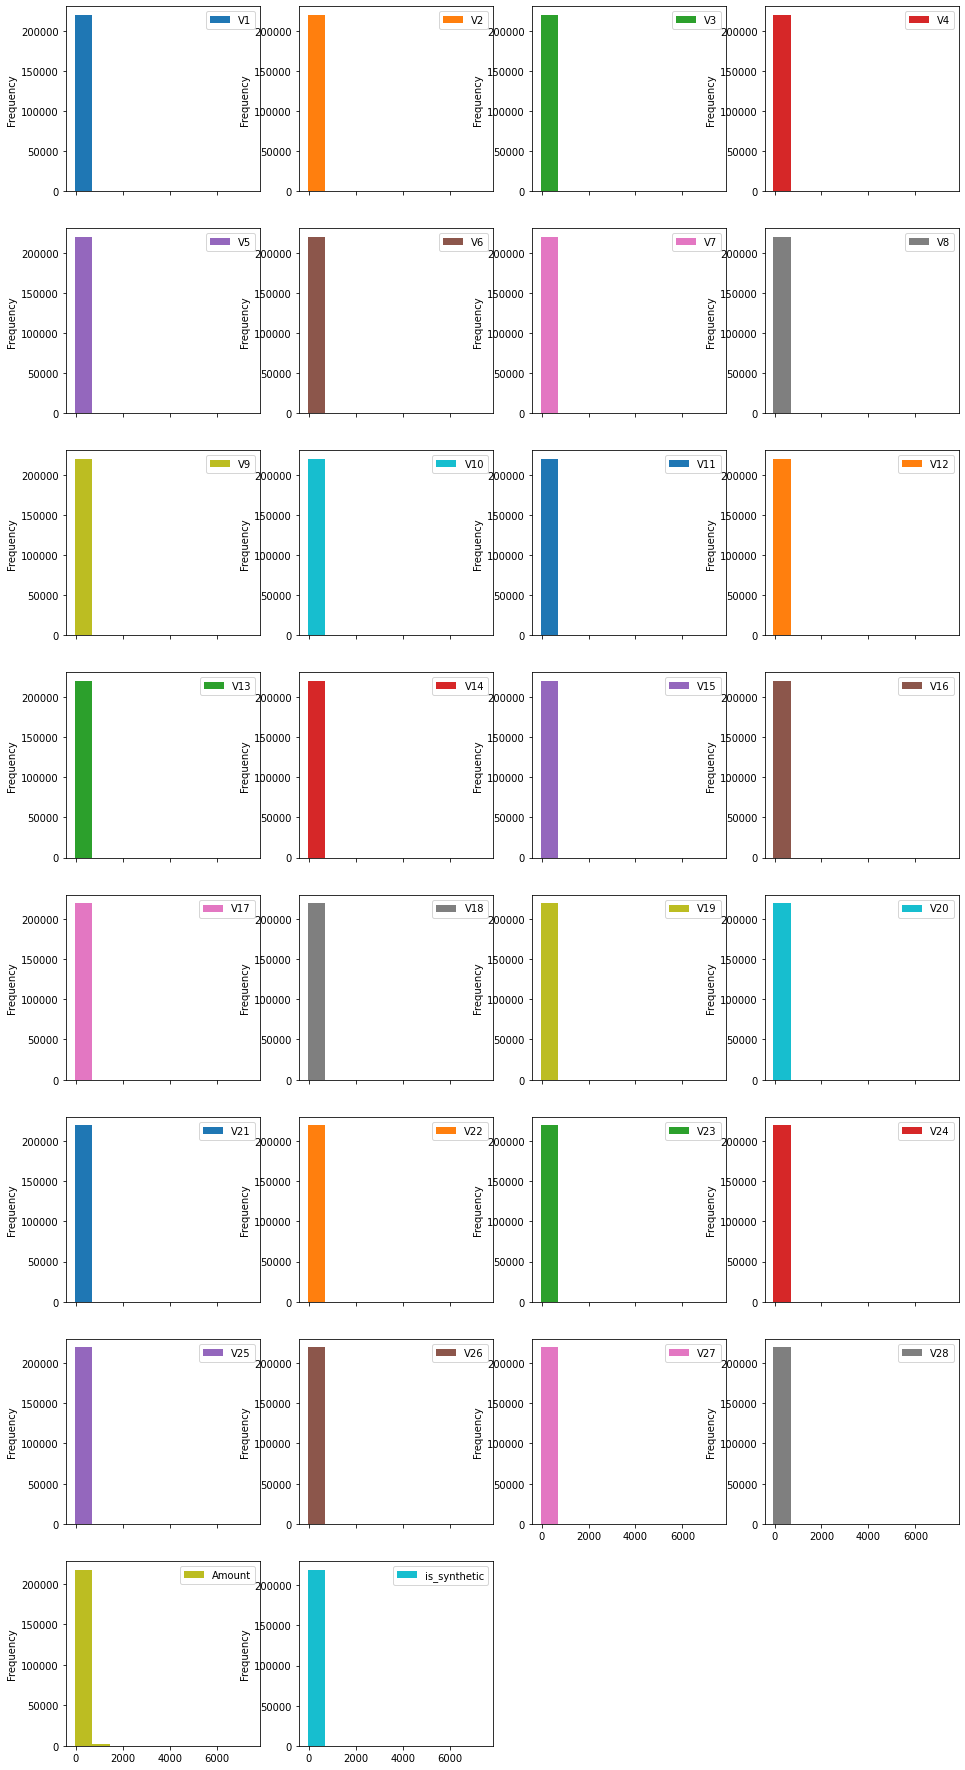

In [25]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

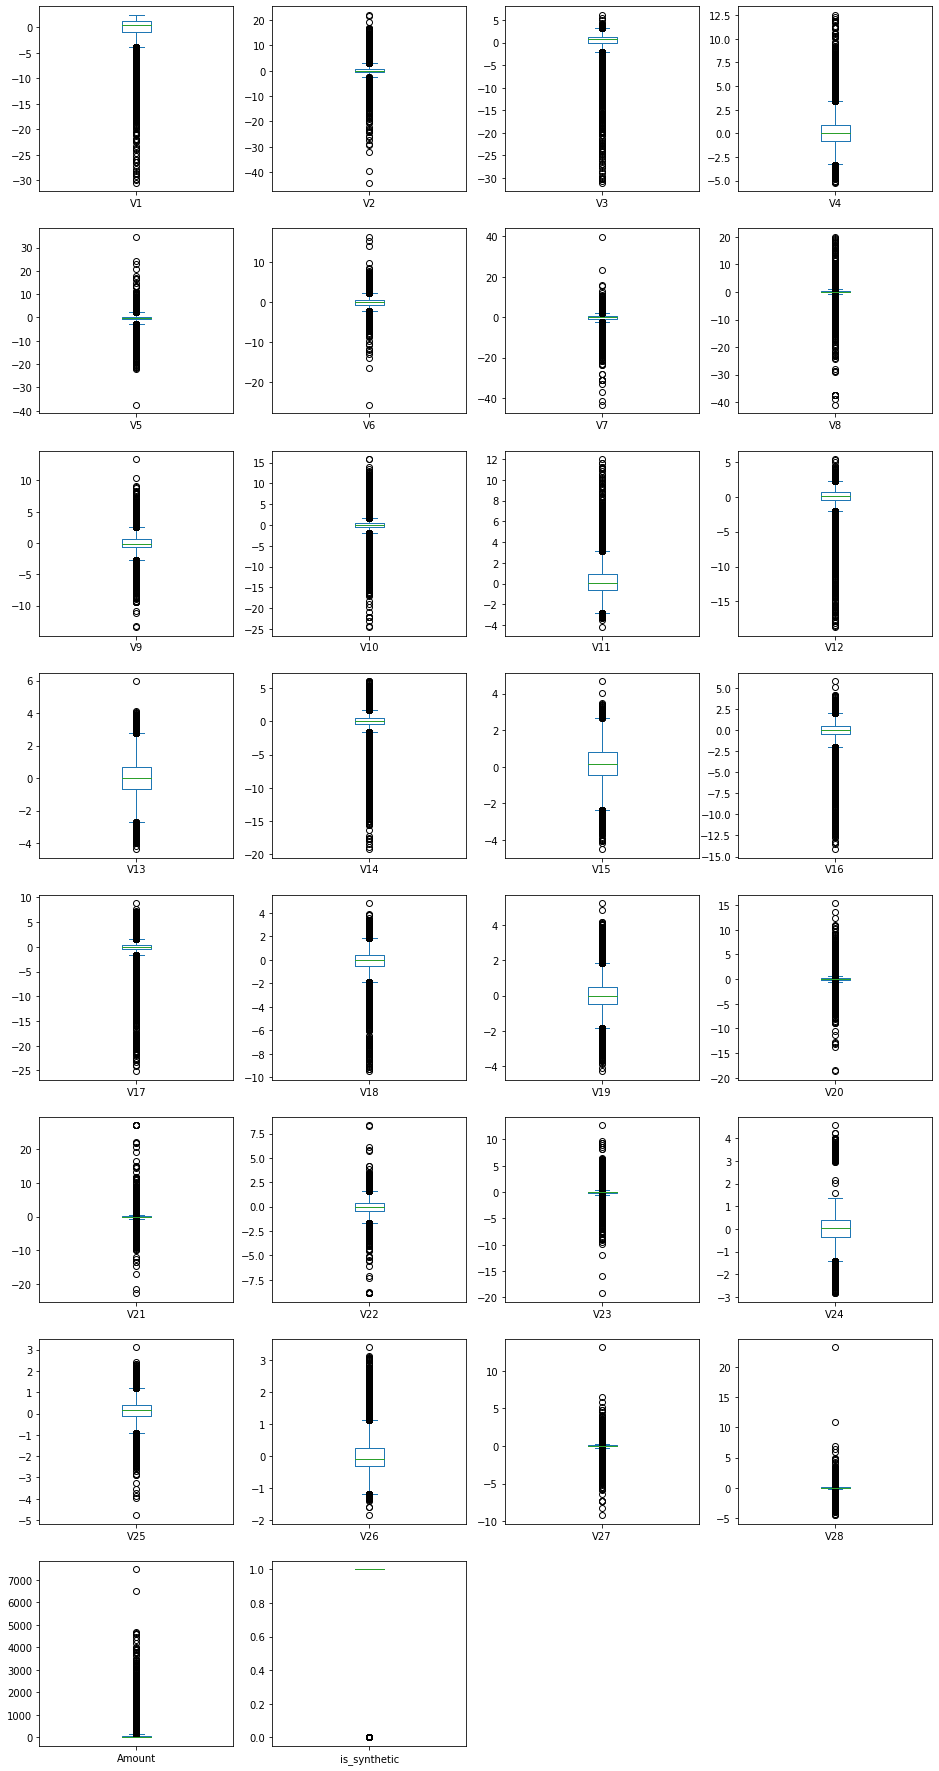

In [26]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

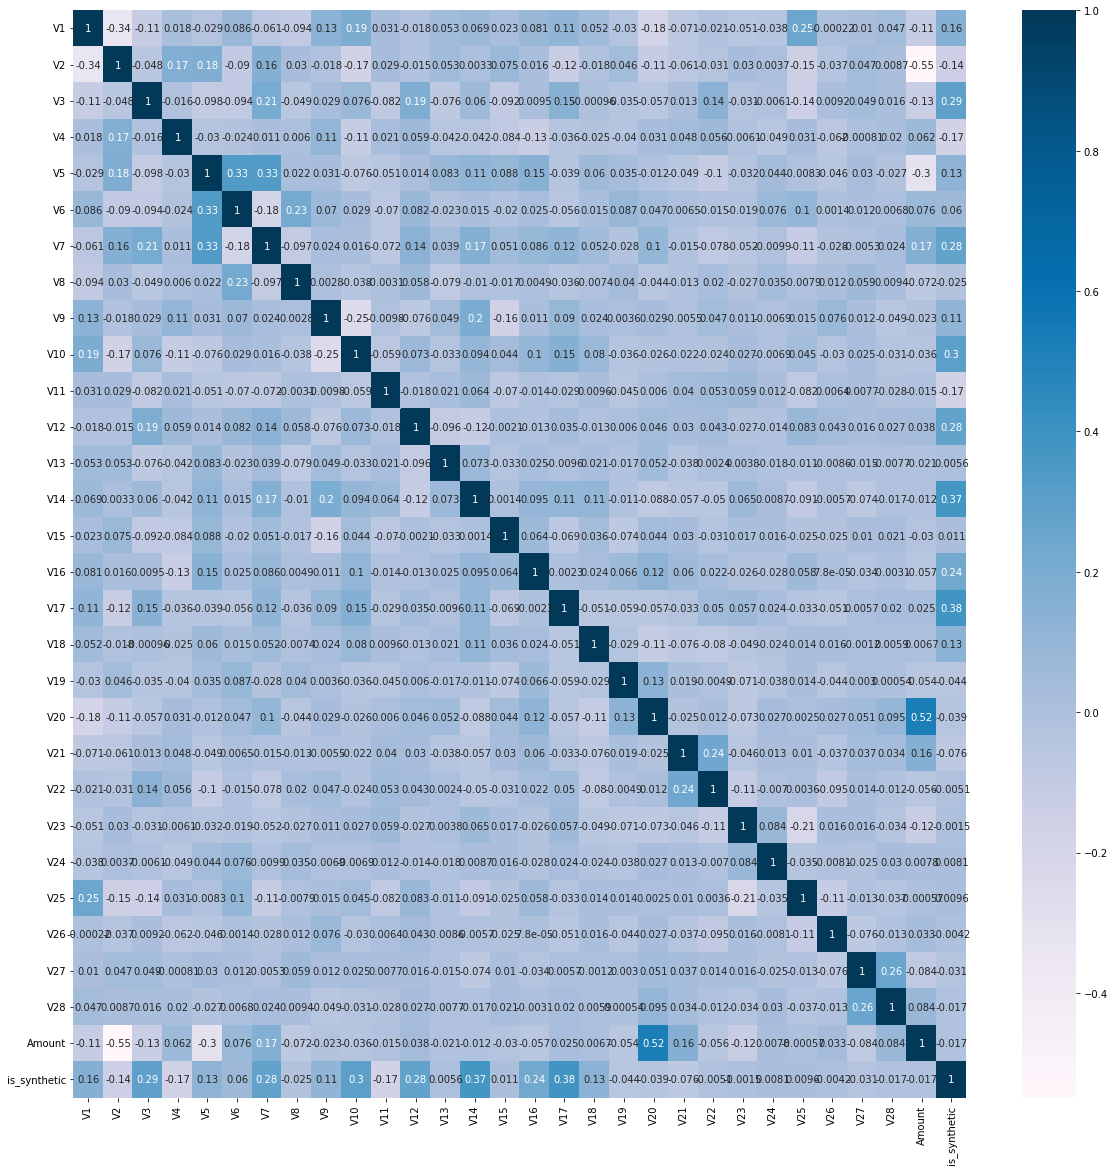

In [27]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [28]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [29]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing 

In [30]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['float','int']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="median")),
    ('scaler', preprocessing.StandardScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 30
Number of categorical columns: 0
Total number of columns in the feature dataframe: 30


In [31]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
], remainder='passthrough')

In [32]:
# Finalize the training dataset for the modeling activities
array_features_train = preprocessor.fit_transform(df_features_train)
array_target_train = df_target_train.to_numpy()
# label_encoder = preprocessing.LabelEncoder()
# array_target_train = label_encoder.fit_transform(df_target_train)

In [33]:
# Perform SMOTE transformation on the training data (Block #1 of 2)
X_train_imbal = array_features_train
y_train_imbal = array_target_train
print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

X_train_imbal.shape: (219621, 30) y_train_imbal.shape: (219621,)


In [34]:
# Perform SMOTE transformation on the training data (Block #2 of 2)
print ('Original class distribution - 1: {} | 0: {}'.format((array_target_train==1).sum(), (array_target_train==0).sum()))
# over_sample = SMOTE(sampling_strategy=0.5, random_state=RNG_SEED)
under_sample = RandomUnderSampler(sampling_strategy=0.20, random_state=RNG_SEED)
# steps = [('o', over_sample), ('u', under_sample)]
steps = [('u', under_sample)]
sample_pipeline = Pipeline(steps=steps)
array_features_train, array_target_train = sample_pipeline.fit_resample(X_train_imbal, y_train_imbal)
print ('Resampled class distribution - 1: {} | 0: {}'.format((array_target_train==1).sum(), (array_target_train==0).sum()))

Original class distribution - 1: 961 | 0: 218660
Resampled class distribution - 1: 961 | 0: 4805


### 3.b) Train and Evaluate the Random Forest Model

In [35]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
RF_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
RF_model.compile(metrics=DEFAULT_METRICS)
RF_model.fit(x=array_features_train, y=array_target_train)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Use /tmp/tmpadq0x64w as temporary training directory
Reading training dataset...


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:05.670029. Found 5766 examples.
Training model...
Model trained in 0:00:06.708028
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
Total time for model fitting: 0:00:15.894786


In [36]:
RF_model.evaluate(x=array_features_train, y=array_target_train)

181/181 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - auc: 0.9974


[0.0, 0.9973945617675781]

In [37]:
RF_model.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (30):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.12
	data:0.13
	data:0.14
	data:0.15
	data:0.16
	data:0.17
	data:0.18
	data:0.19
	data:0.2
	data:0.20
	data:0.21
	data:0.22
	data:0.23
	data:0.24
	data:0.25
	data:0.26
	data:0.27
	data:0.28
	data:0.29
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "data:0.29"  0.236250 ################
    2. "data:0.13"  0.163440 ########
    3. "data:0.16"  0.132277 ####
    4.  "data:0.2"  0.128773 ####
    5.  "data:0.7"  0.127398 ####
    6.  "data:0.3"  0.118601 ###
    7.  "data:0.9"  0.113442 ##
    8.

### 3.c) Train and Evaluate the Decision Trees Model

In [38]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
CART_model = tfdf.keras.CartModel(task = tfdf.keras.Task.CLASSIFICATION)
CART_model.compile(metrics=DEFAULT_METRICS)
CART_model.fit(x=array_features_train, y=array_target_train)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Use /tmp/tmptgpaypdk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.562067. Found 5766 examples.
Training model...
Model trained in 0:00:00.076579
Compiling model...
Model compiled.
Total time for model fitting: 0:00:01.087595


In [39]:
CART_model.evaluate(x=array_features_train, y=array_target_train)

181/181 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - auc: 0.9444


[0.0, 0.9443634748458862]

In [40]:
CART_model.summary()

Model: "cart_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (30):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.12
	data:0.13
	data:0.14
	data:0.15
	data:0.16
	data:0.17
	data:0.18
	data:0.19
	data:0.2
	data:0.20
	data:0.21
	data:0.22
	data:0.23
	data:0.24
	data:0.25
	data:0.26
	data:0.27
	data:0.28
	data:0.29
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "data:0.13"  1.000000 ################
    2.  "data:0.9"  0.500000 ######
    3. "data:0.16"  0.340909 ###
    4. "data:0.20"  0.194805 
    5.  "data:0.0"  0.185185 
    6. "data:0.28"  0.178571 
    7.  "data:0.3"  0.178571 
    8.  "data:0.6"  0.166667 
 


### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [41]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
GBT_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)
GBT_model.compile(metrics=DEFAULT_METRICS)
GBT_model.fit(x=array_features_train, y=array_target_train)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Use /tmp/tmp_29sibze as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.523940. Found 5766 examples.
Training model...
Model trained in 0:00:03.828196
Compiling model...
Model compiled.
Total time for model fitting: 0:00:04.806437


In [42]:
GBT_model.evaluate(x=array_features_train, y=array_target_train)

181/181 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - auc: 0.9572


[0.0, 0.9571718573570251]

In [43]:
GBT_model.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (30):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.12
	data:0.13
	data:0.14
	data:0.15
	data:0.16
	data:0.17
	data:0.18
	data:0.19
	data:0.2
	data:0.20
	data:0.21
	data:0.22
	data:0.23
	data:0.24
	data:0.25
	data:0.26
	data:0.27
	data:0.28
	data:0.29
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "data:0.29"  0.329682 ################
    2.  "data:0.3"  0.222914 ####
    3. "data:0.13"  0.213876 ###
    4.  "data:0.2"  0.203941 ##
    5.  "data:0.9"  0.203360 ##
    6. "data:0.17"  0.199876 ##
    7. "data:0.16"  0.196685 #

In [44]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [45]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [46]:
# Not applicable for this iteration of modeling

In [47]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [48]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [49]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
final_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
# final_model = tfdf.keras.CartModel(task = tfdf.keras.Task.CLASSIFICATION)
# final_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)
final_model.compile(metrics=DEFAULT_METRICS)

# Train the model.
final_model.fit(x=array_features_train, y=array_target_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmp50c9r7in as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.575934. Found 5766 examples.
Training model...
Model trained in 0:00:06.820379
Compiling model...
Model compiled.
Model training time: 0:00:07.853651 



In [50]:
final_model.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (30):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.12
	data:0.13
	data:0.14
	data:0.15
	data:0.16
	data:0.17
	data:0.18
	data:0.19
	data:0.2
	data:0.20
	data:0.21
	data:0.22
	data:0.23
	data:0.24
	data:0.25
	data:0.26
	data:0.27
	data:0.28
	data:0.29
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "data:0.29"  0.236250 ################
    2. "data:0.13"  0.163440 ########
    3. "data:0.16"  0.132277 ####
    4.  "data:0.2"  0.128773 ####
    5.  "data:0.7"  0.127398 ####
    6.  "data:0.3"  0.118601 ###
    7.  "data:0.9"  0.113442 ##
    

### 5.b) Load Test Dataset and Make Predictions

In [51]:
df_features_test = pd.read_csv(TEST_DATASET)
df_features_test.pop('Time')
df_features_test['is_synthetic'] = 1

# Take a peek at the dataframe after import
print(df_features_test.head())

       id        V1        V2        V3        V4        V5        V6  \
0  219129  2.115519 -0.691809 -1.305514 -0.685655 -0.641265 -0.764784   
1  219130  1.743525 -1.681429 -0.547387 -1.061113 -0.695825  2.458824   
2  219131  2.205568 -1.571445 -0.238965 -1.662517 -1.652324 -0.054701   
3  219132  1.989728 -0.972909 -1.938259 -1.440129 -0.166855 -0.794048   
4  219133 -1.943548 -1.668761  0.363601 -0.977610  2.684779 -2.037681   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0 -0.924262 -0.023030 -0.230126  ...  0.241708  0.682524  0.037769 -0.546859   
1 -1.632859  1.073529  1.068183  ...  0.543278  1.294571  0.309541  3.703925   
2 -1.682064  0.105613 -1.177858  ... -0.131527  0.086623  0.291375  0.739087   
3  0.252889 -0.399789  2.079398  ... -0.080115 -0.010732 -0.038550  0.656830   
4  0.039709 -0.048895 -0.281749  ...  0.083389 -0.306918  0.247822 -0.391799   

        V25       V26       V27       V28  Amount  is_synthetic  
0 -0.123055 -0

In [52]:
df_features_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146087 entries, 0 to 146086
Data columns (total 31 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            146087 non-null  int64  
 1   V1            146087 non-null  float64
 2   V2            146087 non-null  float64
 3   V3            146087 non-null  float64
 4   V4            146087 non-null  float64
 5   V5            146087 non-null  float64
 6   V6            146087 non-null  float64
 7   V7            146087 non-null  float64
 8   V8            146087 non-null  float64
 9   V9            146087 non-null  float64
 10  V10           146087 non-null  float64
 11  V11           146087 non-null  float64
 12  V12           146087 non-null  float64
 13  V13           146087 non-null  float64
 14  V14           146087 non-null  float64
 15  V15           146087 non-null  float64
 16  V16           146087 non-null  float64
 17  V17           146087 non-null  float64
 18  V18 

In [53]:
id_column_name = df_features_test.columns[0]
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission[id_column_name] = df_features_test[id_column_name]
print(df_kaggle_submission.head())

       id
0  219129
1  219130
2  219131
3  219132
4  219133


In [54]:
# Dropping unique identifier and unnecessary features
df_features_test.drop(columns=[id_column_name,], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

         V1        V2        V3        V4        V5        V6        V7  \
0  2.115519 -0.691809 -1.305514 -0.685655 -0.641265 -0.764784 -0.924262   
1  1.743525 -1.681429 -0.547387 -1.061113 -0.695825  2.458824 -1.632859   
2  2.205568 -1.571445 -0.238965 -1.662517 -1.652324 -0.054701 -1.682064   
3  1.989728 -0.972909 -1.938259 -1.440129 -0.166855 -0.794048  0.252889   
4 -1.943548 -1.668761  0.363601 -0.977610  2.684779 -2.037681  0.039709   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0 -0.023030 -0.230126  0.220610  ...  0.241708  0.682524  0.037769 -0.546859   
1  1.073529  1.068183  0.483337  ...  0.543278  1.294571  0.309541  3.703925   
2  0.105613 -1.177858  1.626352  ... -0.131527  0.086623  0.291375  0.739087   
3 -0.399789  2.079398 -1.225592  ... -0.080115 -0.010732 -0.038550  0.656830   
4 -0.048895 -0.281749 -0.341879  ...  0.083389 -0.306918  0.247822 -0.391799   

        V25       V26       V27       V28  Amount  is_synthetic  
0 

In [55]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (146087, 30) to array_features_test.shape: (146087, 30)


In [56]:
# Make batched predictions
test_predictions =  final_model.predict(array_features_test)
print(test_predictions)

4566/4566 [==============================] - 15s 3ms/step
[[0.20666654]
 [0.08333332]
 [0.00666667]
 ...
 [0.04666667]
 [0.03333334]
 [0.02      ]]


In [57]:
df_sample_submission = pd.read_csv(SUBMISSION_TEMPLATE)
df_sample_submission.drop(columns=[id_column_name], inplace=True)
submission_header = list(df_sample_submission.columns)[0]
print(submission_header)

Class


In [58]:
df_kaggle_submission[submission_header] = test_predictions
df_kaggle_submission[submission_header] = df_kaggle_submission[submission_header]
print(df_kaggle_submission.head())

       id     Class
0  219129  0.206667
1  219130  0.083333
2  219131  0.006667
3  219132  0.093333
4  219133  0.050000


In [59]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = SUBMISSION_FILE + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_decisionforests_20230203-0107.csv


In [60]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [61]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:01:37.431822
